In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "ipba-17-time-series-forecasting-png"

In [2]:
train_data <- read.csv('/kaggle/input/ipba-17-time-series-forecasting-png/train.csv')
test_data <- read.csv('/kaggle/input/ipba-17-time-series-forecasting-png/test.csv')
holidays <- read.csv('/kaggle/input/ipba-17-time-series-forecasting-png/holidays.csv')

In [3]:
library(tidyverse) # metapackage of all tidyverse packages

library(forecast)
library(dplyr)
library(lubridate)
library(ggplot2)
library(tseries)
library(zoo)
library(prophet)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, flatten, flatten_chr, flatten_dbl, flatten_int, flatten_lgl,
    flatten_raw, invoke, splice




In [4]:
# Summary Statistics
head(train_data);dim(train_data)
head(test_data);dim(test_data)
head(holidays);dim(holidays)
summary(train_data);summary(test_data);summary(holidays)

,date,transactions
,<chr>,<int>
1,01-01-2013,770
2,02-01-2013,93215
3,03-01-2013,78504
4,04-01-2013,78494
5,05-01-2013,93573
6,06-01-2013,90464


[1] 1455    2

,date,id
,<chr>,<int>
1,01-01-2017,0
2,02-01-2017,1
3,03-01-2017,2
4,04-01-2017,3
5,05-01-2017,4
6,06-01-2017,5


[1] 227   2

,Date,Holidays
,<chr>,<int>
1,02-03-2012,1
2,01-04-2012,1
3,12-04-2012,1
4,14-04-2012,1
5,21-04-2012,1
6,12-05-2012,1


[1] 312   2

     date            transactions   
 Length:1455        Min.   :   770  
 Class :character   1st Qu.: 75596  
 Mode  :character   Median : 80387  
                    Mean   : 83491  
                    3rd Qu.: 90166  
                    Max.   :171169  

     date                 id       
 Length:227         Min.   :  0.0  
 Class :character   1st Qu.: 56.5  
 Mode  :character   Median :113.0  
                    Mean   :113.0  
                    3rd Qu.:169.5  
                    Max.   :226.0  

     Date              Holidays    
 Length:312         Min.   :1.000  
 Class :character   1st Qu.:1.000  
 Mode  :character   Median :1.000  
                    Mean   :1.122  
                    3rd Qu.:1.000  
                    Max.   :4.000  

In [5]:
# Data Cleaning & Prep - Convert String to Date format code

str(train_data$date)
str(test_data$date)
str(holidays$Date)

 chr [1:1455] "01-01-2013" "02-01-2013" "03-01-2013" "04-01-2013" ...
 chr [1:227] "01-01-2017" "02-01-2017" "03-01-2017" "04-01-2017" ...
 chr [1:312] "02-03-2012" "01-04-2012" "12-04-2012" "14-04-2012" ...


In [6]:
#Convert String to Date format code
train_data$date = as.Date(train_data$date)
test_data$date = as.Date(test_data$date)
holidays$Date = as.Date(holidays$Date)
names(holidays$Date)<-c('date','holidays')
class(train_data$date);class(test_data$date);class(holidays$Date)
str(train_data$date)
str(test_data$date)
str(holidays$Date)

[1] "Date"

[1] "Date"

[1] "Date"

 Date[1:1455], format: "1-01-20" "2-01-20" "3-01-20" "4-01-20" "5-01-20" "6-01-20" "7-01-20" ...
 Date[1:227], format: "1-01-20" "2-01-20" "3-01-20" "4-01-20" "5-01-20" "6-01-20" "7-01-20" ...
 Date[1:312], format: "2-03-20" "1-04-20" "12-04-20" "14-04-20" "21-04-20" "12-05-20" ...


In [7]:
train_data <- train_data %>% arrange(date)
test_data <- test_data %>% arrange(date)

nrow(train_data)
sum(is.na(train_data)) 

nrow(test_data)
sum(is.na(test_data))

[1] 1455

[1] 0

[1] 227

[1] 0

In [8]:
missing_train_data <- sum(is.na(train_data$date))


In [9]:
missing_test_data <- sum(is.na(test_data$date))


In [10]:
cat("Missing values in train_data:", missing_train_data, "\n")
cat("Missing values in test_data:", missing_test_data, "\n")

Missing values in train_data: 0 
Missing values in test_data: 0 


In [11]:

head(holidays)
head(train_data)
head(test_data)

,Date,Holidays
,<date>,<int>
1,2-03-20,1
2,1-04-20,1
3,12-04-20,1
4,14-04-20,1
5,21-04-20,1
6,12-05-20,1


,date,transactions
,<date>,<int>
1,1-01-20,770
2,1-01-20,1327
3,1-01-20,2202
4,1-02-20,78302
5,1-02-20,100397
6,1-02-20,98364


,date,id
,<date>,<int>
1,1-01-20,0
2,1-02-20,31
3,1-03-20,59
4,1-04-20,90
5,1-05-20,120
6,1-06-20,151


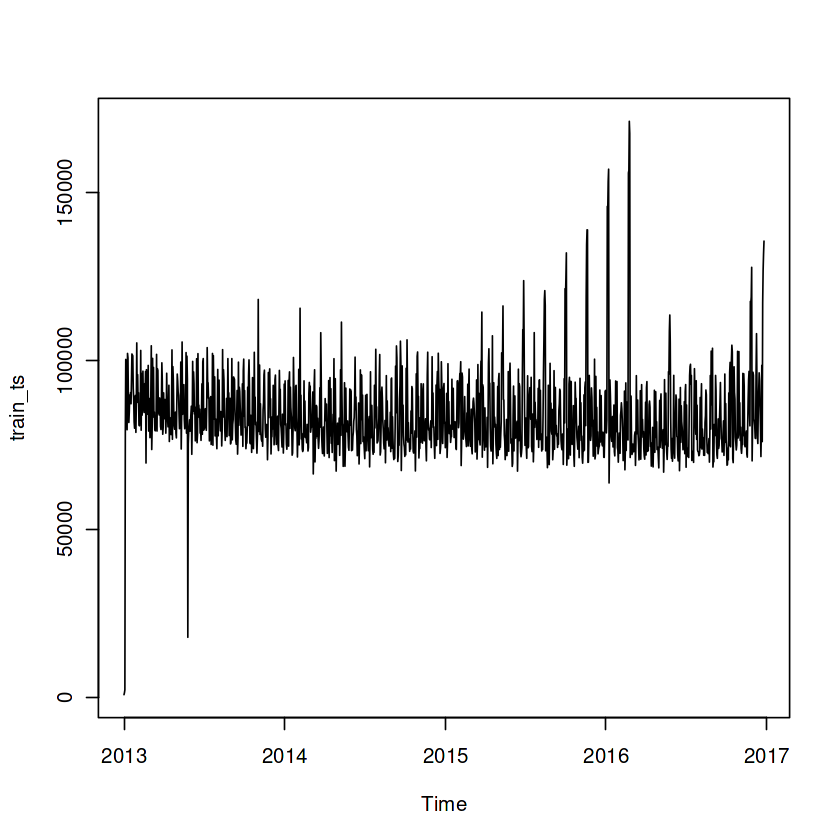

In [12]:
train_ts = ts(train_data$transactions, frequency = 365, start = c(2013, 1))
cleaned_data = tsclean(train_ts)
plot(train_ts)

In [13]:
# Perform ADF Test -Augmented Dickey-Fuller Test
adf_result <- adf.test(cleaned_data)
summary(adf_result)
print(adf_result)

Warning message in adf.test(cleaned_data):
“p-value smaller than printed p-value”


            Length Class  Mode     
statistic   1      -none- numeric  
parameter   1      -none- numeric  
alternative 1      -none- character
p.value     1      -none- numeric  
method      1      -none- character
data.name   1      -none- character


	Augmented Dickey-Fuller Test

data:  cleaned_data
Dickey-Fuller = -6.9201, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary



In [14]:
# ARIMA Model
model_arima <- arima(cleaned_data, order = c(1,0,1))
summary(model_arima)


Call:
arima(x = cleaned_data, order = c(1, 0, 1))

Coefficients:
         ar1      ma1   intercept
      0.4503  -0.1197  83152.1873
s.e.  0.0599   0.0648    394.8403

sigma^2 estimated as 88541924:  log likelihood = -15377.13,  aic = 30762.27

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set 2.341404 9409.672 7476.893 -1.179682 8.848857 0.8821084
                     ACF1
Training set -0.002007772

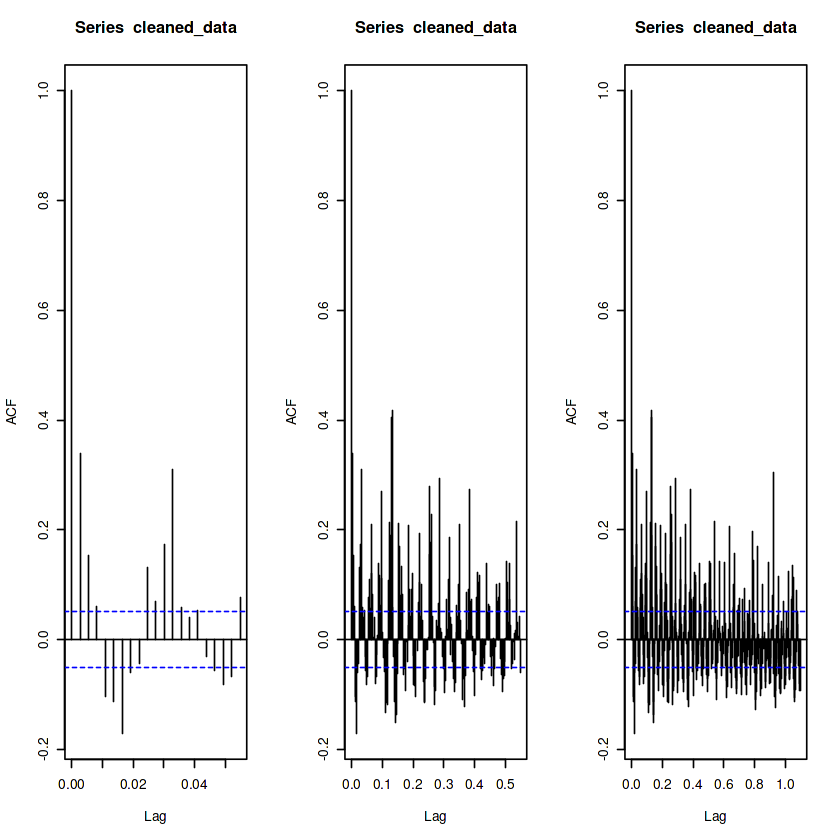

In [15]:
# MA term ? - ACF plot 
par(mfrow=c(1, 3))
acf(cleaned_data,lag.max =20) # Mostly all the correlated time period will be in last 20 time frame.
acf(cleaned_data,lag.max =200)
acf(cleaned_data,lag.max =400)
par(mfrow=c(1, 1))

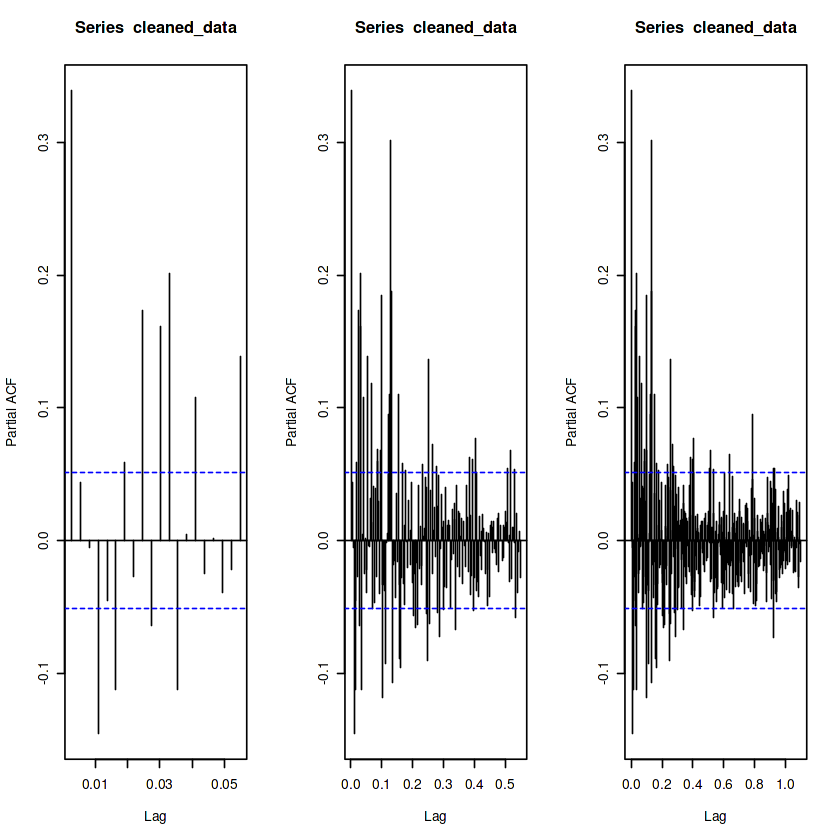

In [16]:
# AR term - PACF plot
par(mfrow=c(1, 3))
pacf(cleaned_data, lag.max = 20)
pacf(cleaned_data, lag.max = 200)
pacf(cleaned_data, lag.max = 400)
par(mfrow=c(1, 1))

In [17]:
# ARIMAX Model - with auto.arima (Holiday)
model <- auto.arima(cleaned_data)
summary(model)

Series: cleaned_data 
ARIMA(4,1,5) 

Coefficients:
          ar1     ar2      ar3      ar4      ma1      ma2     ma3     ma4
      -0.2481  1.1183  -0.0584  -0.8344  -0.4964  -1.4414  0.8160  0.7541
s.e.   0.0397  0.0324   0.0457   0.0358   0.0565   0.0277  0.1027  0.0313
          ma5
      -0.6035
s.e.   0.0566

sigma^2 = 79440365:  log likelihood = -15285.32
AIC=30590.64   AICc=30590.79   BIC=30643.46

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE     MASE       ACF1
Training set 37.36595 8882.251 6808.448 -0.9846441 8.041626 0.597526 0.04088999

In [18]:
mod_ses <- ses(cleaned_data)

In [19]:
pred_ses<-forecast(mod_ses, length(test_data))


In [20]:
# Calculate accuracy metrics for the fitted values
accuracy(mod_ses$fitted, cleaned_data)  # Replace 'cleaned_data' with your training data

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,36.69142,9825.839,7855.087,-1.215635,9.246583,0.2964826,0.856464


          Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2016.9863       89721.95 77120.97 102322.9 70450.41 108993.5
2016.9890       89721.95 77116.88 102327.0 70444.16 108999.7
2016.9918       89721.95 77112.80 102331.1 70437.91 109006.0
2016.9945       89721.95 77108.71 102335.2 70431.66 109012.2
2016.9973       89721.95 77104.63 102339.3 70425.41 109018.5
2017.0000       89721.95 77100.54 102343.4 70419.17 109024.7
2017.0027       89721.95 77096.46 102347.4 70412.93 109031.0
2017.0055       89721.95 77092.38 102351.5 70406.69 109037.2
2017.0082       89721.95 77088.30 102355.6 70400.45 109043.5
2017.0110       89721.95 77084.22 102359.7 70394.21 109049.7


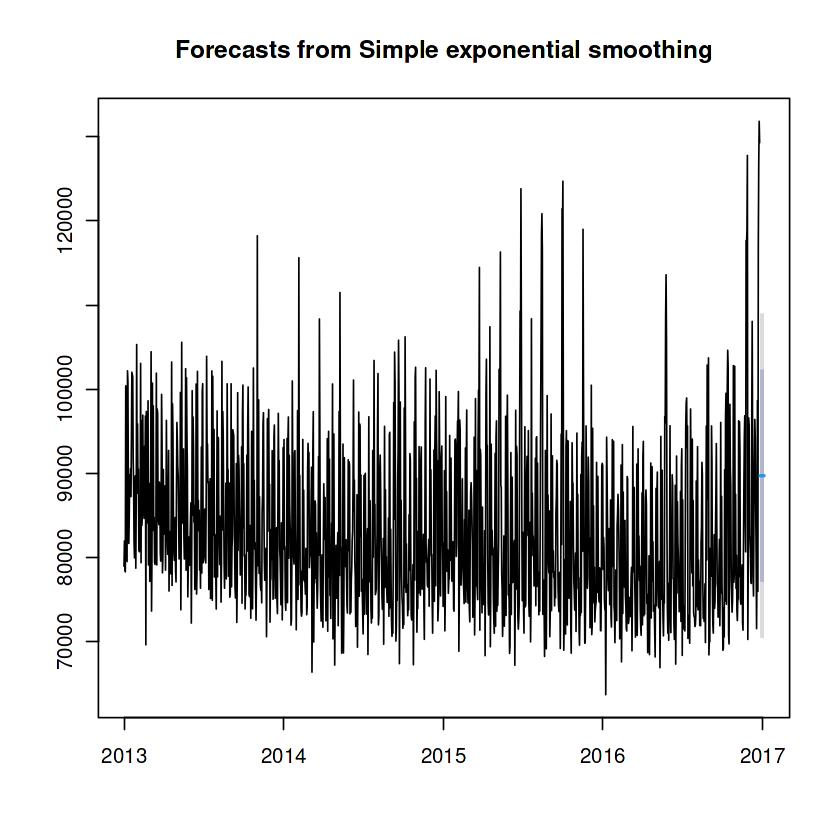

In [21]:
# Print the forecasted values
print(pred_ses)
# Plot the forecasted values
plot(pred_ses)

In [22]:
mod_holt <- holt(cleaned_data)


In [23]:
pred_holt <- forecast(mod_holt, h = length(test_data))


In [24]:
accuracy(mod_holt$fitted, cleaned_data)  # Replace 'cleaned_data' with your training data


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-237.7993,10230.78,8199.628,-1.509617,9.694957,0.2613101,0.9072103


In [25]:
print(pred_holt)


          Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2016.9863       107309.2 94179.83 120438.5 87229.58 127388.7
2016.9890       107887.0 94582.46 121191.6 87539.46 128234.6


In [26]:
# holt winter model 
mod_hw<-HoltWinters(cleaned_data)
pred_hw<-forecast(mod_hw,h=length(test_data))

In [27]:
# Calculate accuracy metrics for the fitted values
accuracy(mod_hw$fitted, cleaned_data)  # Replace 'cleaned_data' with  training data

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,376.8816,11901.54,8688.365,-0.781001,10.2795,0.3038353,1.035738


          Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2016.9863       85581.41 70329.63 100833.2 62255.82 108907.0
2016.9890       87895.10 72641.86 103148.3 64567.28 111222.9


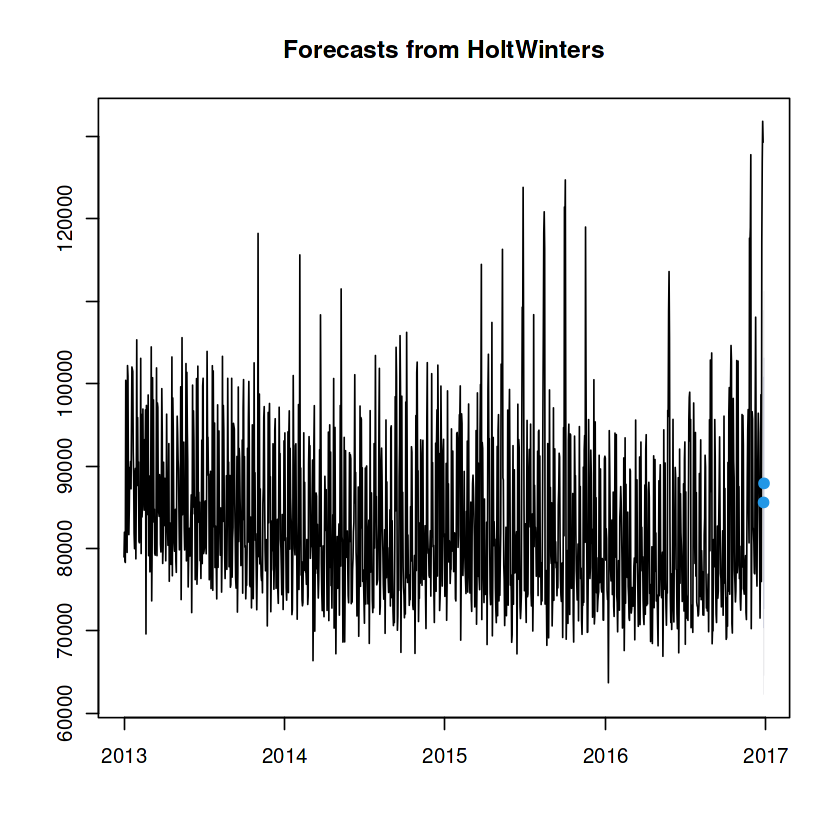

In [28]:
# Print the forecasted values
print(pred_hw)
# Plot the forecasted values
plot(pred_hw)

In [29]:
# Calculate Performance Metrics
# 1 point for (ME, RMSE, MAE, MPE, MAPE)
model <- auto.arima(cleaned_data)
summary(model)

Series: cleaned_data 
ARIMA(4,1,5) 

Coefficients:
          ar1     ar2      ar3      ar4      ma1      ma2     ma3     ma4
      -0.2481  1.1183  -0.0584  -0.8344  -0.4964  -1.4414  0.8160  0.7541
s.e.   0.0397  0.0324   0.0457   0.0358   0.0565   0.0277  0.1027  0.0313
          ma5
      -0.6035
s.e.   0.0566

sigma^2 = 79440365:  log likelihood = -15285.32
AIC=30590.64   AICc=30590.79   BIC=30643.46

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE     MASE       ACF1
Training set 37.36595 8882.251 6808.448 -0.9846441 8.041626 0.597526 0.04088999

In [30]:
# ARIMAX Model - with auto.arima (Holiday)
# Rename the 'Date' column in the 'holidays' dataset to 'date'
names(holidays)[names(holidays) == "Date"] <- "date"

In [31]:
# plot with Actual and Predicted Values
# Sample data (replace with your own dataset)
set.seed(42)
date_sequence <- seq.Date(from = as.Date("2023-01-01"), by = "days", length.out = 100)
data <- data.frame(Date = date_sequence, Value = rnorm(100))

In [32]:
# Split the data into training and testing sets (70% train, 30% test)
set.seed(42)  # For reproducibility
split_index <- floor(0.7 * nrow(data))
train_data <- data[1:split_index, ]
test_data <- data[(split_index + 1):nrow(data), ]

In [33]:
# Assuming you're using linear regression for forecasting
model <- lm(Value ~ as.numeric(1:nrow(train_data)), data = train_data)

In [34]:
# Forecast the testing data
forecasted_values <- predict(model, newdata = data.frame(as.numeric(1:nrow(test_data))))

Warning message:
“'newdata' had 30 rows but variables found have 70 rows”


In [35]:
# Create a subset of forecasted values to match the number of rows in test_data
forecasted_values_subset <- forecasted_values[1:nrow(test_data)]

In [36]:
# Add forecasted values to the test_data data frame
test_data$Forecasted <- forecasted_values_subset

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


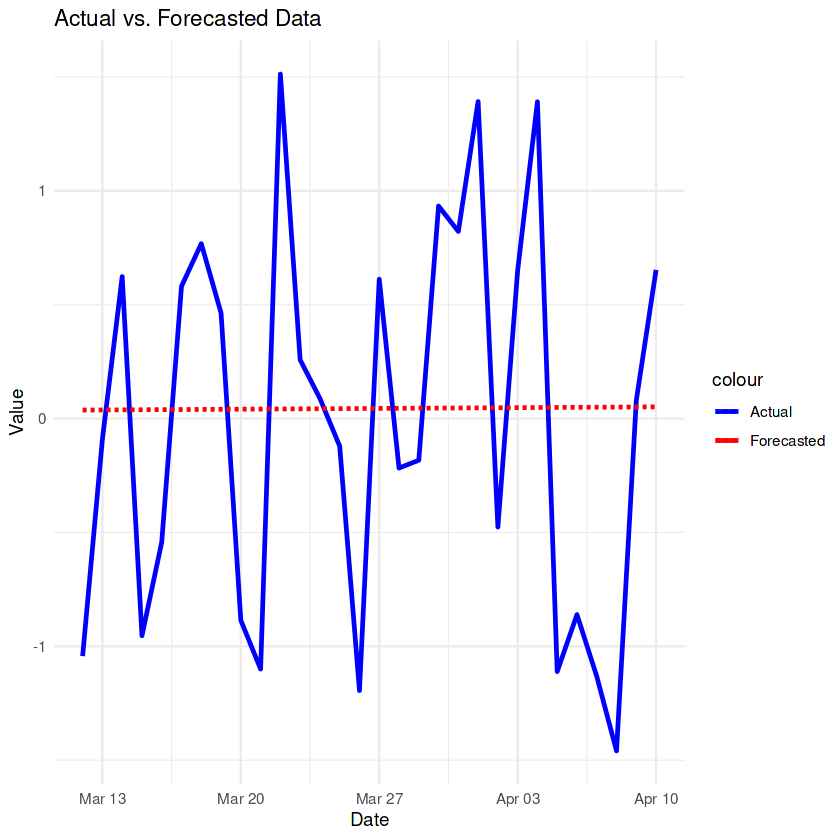

In [37]:
library(ggplot2)
ggplot(test_data, aes(x = Date)) +
  geom_line(aes(y = Value, color = "Actual"), size = 1) +
  geom_line(aes(y = Forecasted, color = "Forecasted"), size = 1, linetype = "dashed") +
  labs(x = "Date", y = "Value", title = "Actual vs. Forecasted Data") +
  scale_color_manual(values = c("Actual" = "blue", "Forecasted" = "red")) +
  theme_minimal()

In [38]:
head(test_data$Forecasted)

[1] 0.03742210 0.03790722 0.03839235 0.03887747 0.03936259 0.03984771

In [39]:
submission<- data.frame(test_data$Forecasted,test_data$Forecasted)
colnames(submission)<- c('id','price')

In [40]:
head(submission)


,id,price
,<dbl>,<dbl>
1,0.03742210,0.03742210
2,0.03790722,0.03790722
3,0.03839235,0.03839235
4,0.03887747,0.03887747
5,0.03936259,0.03936259
6,0.03984771,0.03984771


In [41]:
write.csv(submission,"submission.csv",row.names=FALSE)